In [154]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns 
import bokeh.plotting as bkh
from bokeh.io import output_notebook
from datetime import datetime
from datetime import timedelta
from sgp4.earth_gravity import wgs72 #wgs84, wgs72old
from sgp4.io import twoline2rv
import sklearn.preprocessing as ppimport
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid, Range1d, LabelSet, Label, LogAxis, GMapOptions
from bokeh.io import export_svgs, output_file, show, export_png
from bokeh.transform import dodge
import bokeh.colors as colors
from bokeh.colors import Color
from bokeh.models.ranges import FactorRange
from mpl_toolkits.mplot3d import Axes3D 
import plotly.graph_objects as go
from sgp4.earth_gravity import wgs72 #wgs84, wgs72old
from sgp4.io import twoline2rv
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import leastsq, curve_fit

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [4]:
dfdeb = pickle.load(open('dfdeb_fc.p', 'rb'))
dfdeb_m = pickle.load(open('dfdeb_m_fc.p', 'rb'))

In [5]:
def xyz_model(line1, line2, date):
    satellite = twoline2rv(line1, line2, wgs72)
 #   pass
    #position, velocity = satellite.propagate(
    #2000, 6, 29, 12, 50, 19) # year month day hour min sec
    position, velocity = satellite.propagate(
    date.year, date.month, date.day, date.hour, date.minute, date.second) # year month day hour min sec
    return position

In [6]:
def coordcalt(line1, line2, date):
    xcon = list()
    ycon = list()
    zcon = list()
    for i in range(len(line1)):
        xyz = xyz_model(line1[i], line2[i], datetest)
        xcon.append(xyz[0])
        ycon.append(xyz[1])
        zcon.append(xyz[2])
    return xcon, ycon, zcon

In [7]:
def calorbitxyz(inc, n, raan, ecc, npoints = 100):
    #raan = np.pi / 180
    #inc = np.pi / 180
    x = list()
    y = list()
    z = list()
    mu = 3.986004418E5 * (3600 * 24) ** 2
    earthreq = 6378
    apo = np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.)
    peri = apo * (1 - ecc)
    a = (apo + peri) / 2
    oecc = np.sqrt(1 - ecc ** 2)
    b = a * oecc
    b2 = b * b
    a2 = a * a
    xp = np.linspace(-a, a, npoints) 
    raan_cos = np.cos(raan)
    raan_sin = np.sin(raan)
    inc_cos = np.cos(inc)
    inc_sin = np.sin(inc)
    #print(xp)
    for i in xp:
        x.append(i)
        x.append(i)
        yabs = np.sqrt(b2 - i * i * b2 / a2)
        y.append(yabs)
        y.append(-yabs)
    x = np.array(x)
    y = np.array(y)
    xn = x * raan_cos - y * raan_sin
    yn = y * raan_cos + x * raan_sin
    z = xn * np.sin(inc)
    xn *= np.cos(inc)
    x = xn * raan_cos + yn * raan_sin
    y = yn * raan_cos - xn * raan_sin
    return x, y, z

In [8]:
mu = 3.986004418E5 * (3600 * 24) ** 2
earthreq = 6378
def apogeecal(n, ecc):
    return np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.) * (1 + ecc)
def perigeecal(n, ecc):
    return np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.) * (1 - ecc)

In [9]:
norads = dfdeb.norad.unique()

In [10]:
len(dfdeb_m.loc[norads[0]].line1)

495

In [75]:
#krreg = KernelRidge(alpha=0.01, kernel='linear', gamma='linear', degree=5, coef0=1, kernel_params=None)
krreg = Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
krreg = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
#krreg = KernelRidge(alpha=0.01, kernel='linear', gamma='linear', degree=5, coef0=1, kernel_params=None)
#DecisionTreeRegressor(criterion = 'mae', max_depth = 4, min_samples_split = 2, min_samples_leaf = 1)

In [76]:
dfdebreg = dfdeb_m.drop(['line1', 'line2', 'object_id', 'object_name', 'rcs_size', 'debc',
                        'apo', 'peri', 'country', 'rev_num', 'int_desig', 'ddn_o6', 'm', 'argp', 
                         'epoch_day', 'epoch_year', 'period', 'apogee', 'perigee', 'inclination',
                        'launch'],axis = 1)
dfdebreg.head()

bstar     dn_o2       ecc      inc          n      raan  \
norad date                                                                      
119   2018.916314  0.000116  0.000002  0.009762  66.7291  14.231530  321.6569   
      2018.918618  0.000132  0.000002  0.009762  66.7292  14.231535  319.4778   
      2018.920538  0.000139  0.000002  0.009764  66.7292  14.231539  317.6620   
      2018.921690  0.000145  0.000003  0.009765  66.7292  14.231542  316.5724   
      2018.924762  0.000146  0.000003  0.009766  66.7293  14.231550  313.6672   

                                    datetimes            x            y  \
norad date                                                                
119   2018.916314  2018-12-02 08:54:00.447264  1193.468954  5280.337957   
      2018.918618  2018-12-03 05:08:23.052480   273.176198  6514.606535   
      2018.920538  2018-12-03 22:00:21.864672  -136.651913  6858.366053   
      2018.921690  2018-12-04 08:07:33.134016  -530.784596  7073.827005   
      2018.924762  2018-12-05 11:06:43.134336  -550.232623  7081.356831   

                             z  
norad date                      
119   2018.916314 -4805.947471  
      2018.918618 -3177.855333  
      2018.920538 -2371.102905  
      2018.921690 -1549.948503  
      2018.924762 -1509.005731

In [149]:
oi_num = 1#135#37

0.9798273064435867


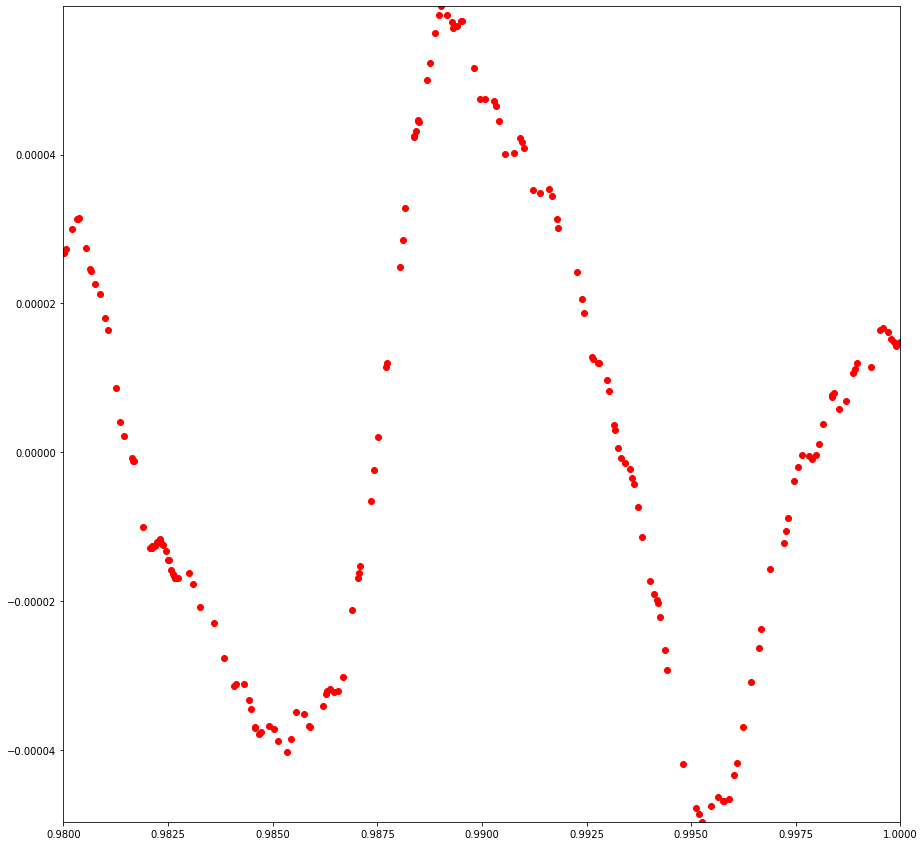

In [150]:
X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)


X_train, X_test, y_train, y_test = train_test_split(X, dfdebreg.loc[norads[oi_num]].n.values,
                                                    test_size=0.33, random_state=42)
degree = 1
poly_features = PolynomialFeatures(degree=degree)
X_trainp = poly_features.fit_transform(X_train)
X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

y_pred = krreg.predict(X_testp)

print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(0.98,1)
plt.ylim(np.min(y_pred),np.max(y_pred))
plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X_test, y_pred, c = 'blue')

0.9972436735772798


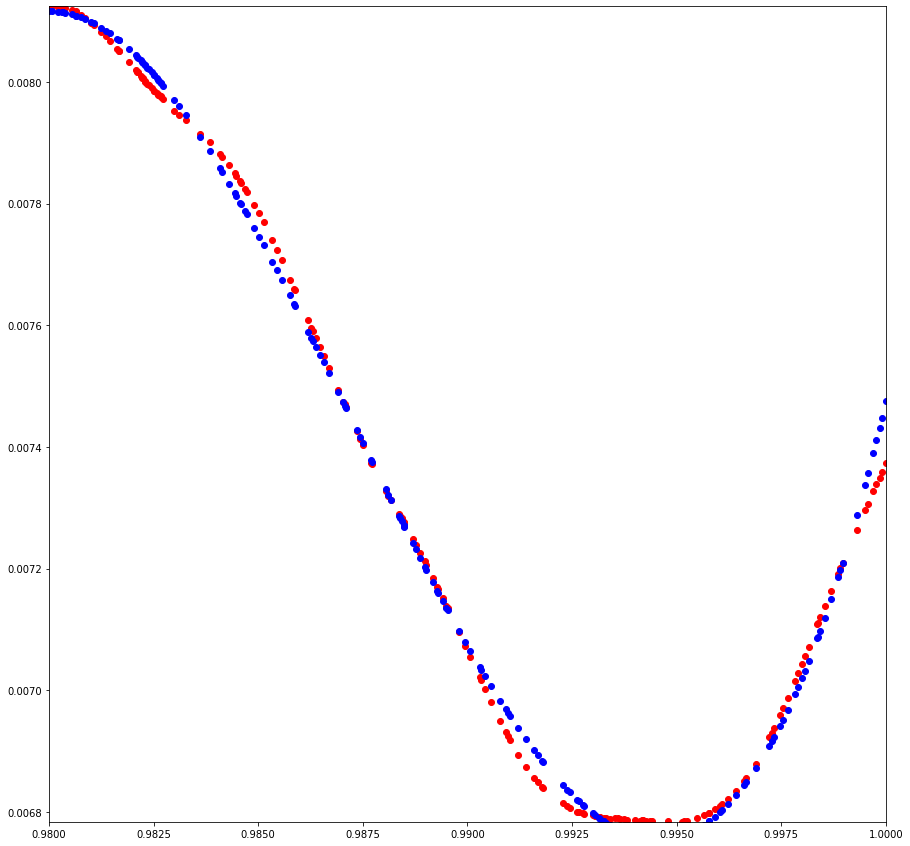

In [151]:
X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), dfdebreg.loc[norads[oi_num]].ecc.values,
                                                    test_size=0.33, random_state=42)

degree = 3
poly_features = PolynomialFeatures(degree=degree)
X_trainp = poly_features.fit_transform(X_train)
X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

y_pred = krreg.predict(X_testp)

print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(0.98,1)
plt.ylim(np.min(y_test),np.max(y_test))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_test, y_pred, c = 'blue')
# better oscillatory interpolation

-0.018816493553075464


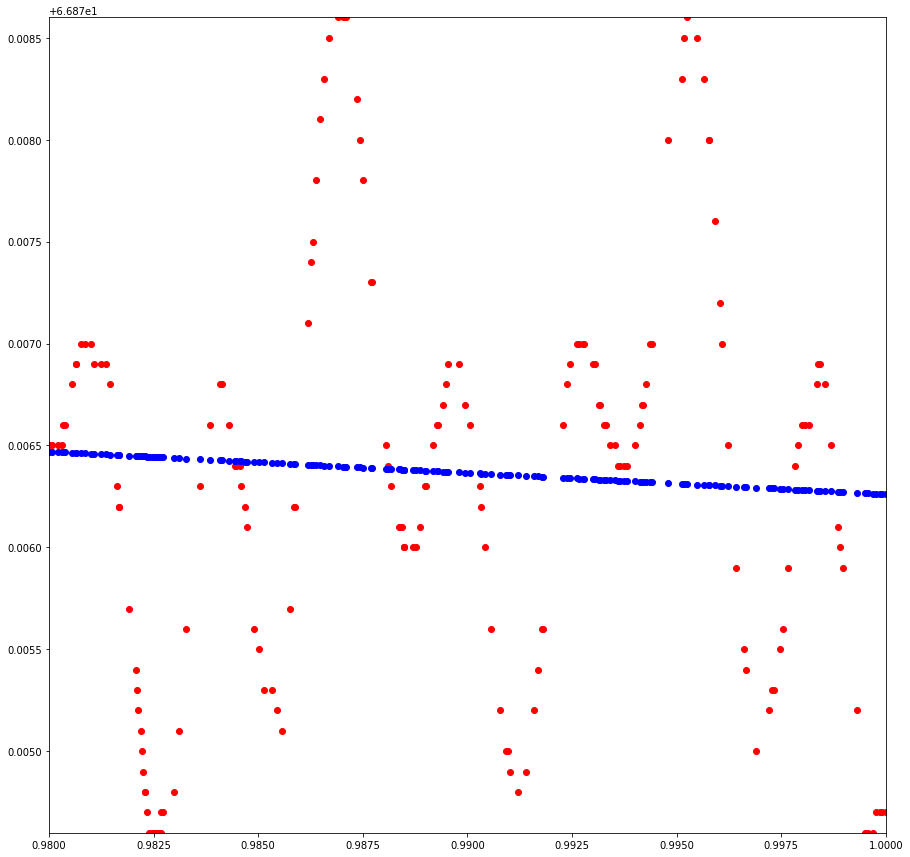

In [152]:
treereg = DecisionTreeRegressor(criterion = 'mae', max_depth = 8, min_samples_split = 2, min_samples_leaf = 1)
X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), dfdebreg.loc[norads[oi_num]].inc.values,
                                                    test_size=0.33, random_state=42)

degree = 1
poly_features = PolynomialFeatures(degree=degree)
X_trainp = poly_features.fit_transform(X_train)
X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

y_pred = krreg.predict(X_testp)

print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(0.98,1)
plt.ylim(np.min(y_test),np.max(y_test))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_test, y_pred, c = 'blue')
# better fourier series interpolation

0.005805669119366419


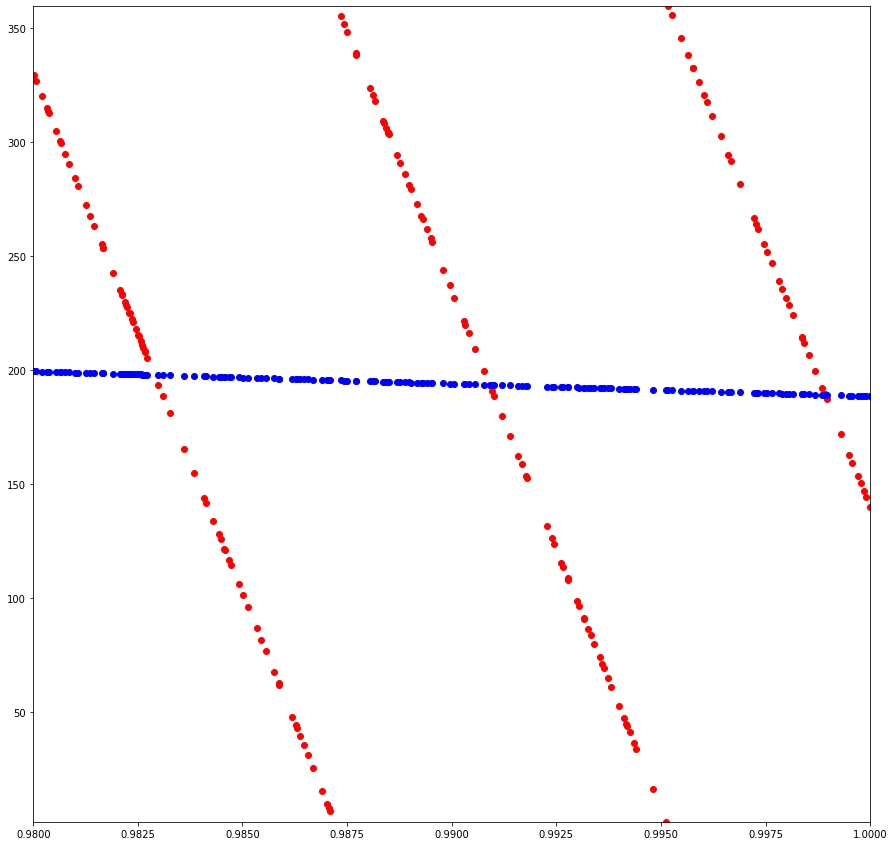

In [153]:
treereg = DecisionTreeRegressor(criterion = 'mae', max_depth = 8, min_samples_split = 2, min_samples_leaf = 1)
X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), dfdebreg.loc[norads[oi_num]].raan.values,
                                                    test_size=0.33, random_state=42)

degree = 1
poly_features = PolynomialFeatures(degree=degree)
X_trainp = poly_features.fit_transform(X_train)
X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

y_pred = krreg.predict(X_testp)

print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(0.98,1.)
plt.ylim(np.min(y_test),np.max(y_test))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_test, y_pred, c = 'blue')
#better  

In [134]:
# Zyklizität in raan, meaning inclined plane changes with time, muss berücksichtigt werden, nicht geosynchrone Orbits
# implement linear regression with modulo 360

In [147]:
360.5 % 360 # linear 

0.5